In [1]:
import torch
from PIL import Image
from torchvision import transforms
import json
import detectron2
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList

In [2]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
torch.cuda.set_device(0)
#torch.cuda.device(2)
print(torch.cuda.current_device())
device = 'cuda:0'

0


In [3]:
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

Available devices  2
Current cuda device  0


In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_BOX_HEAD.FC_DIM = 2048
model = build_model(cfg)
#DetectionCheckpointer(model).load("model_final_f6e8b1.pkl")
model.eval();

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [5]:
print(next(model.parameters()).device)

cuda:0


In [6]:
with open('../mmimdb/split.json') as json_data:
    data = json.load(json_data)

In [7]:
image_names = []

for id in data['train']:
    with open('../mmimdb/dataset/'+str(id)+'.json') as json_data:
        movie = json.load(json_data)
    image_names.append(str(id)+'.jpeg')
    
len(image_names)

15552

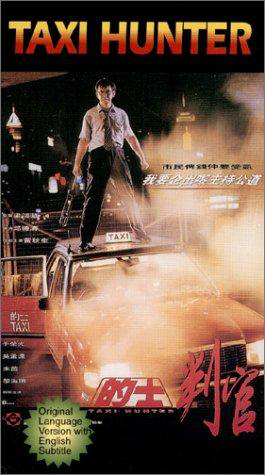

In [8]:
display(Image.open('../mmimdb/dataset/'+image_names[0]).convert('RGB'))

In [262]:
img1 = Image.open('../mmimdb/dataset/'+image_names[0]).convert('RGB')
img2 = Image.open("../mmimdb/dataset/0000005.jpeg").convert('RGB')
img3 = Image.open("../mmimdb/dataset/0005542.jpeg").convert('RGB')
img4 = Image.open("../mmimdb/dataset/0005812.jpeg").convert('RGB')

to_tensor = transforms.ToTensor()

img1 = to_tensor(img1)
img2 = to_tensor(img2)
img3 = to_tensor(img3)
img4 = to_tensor(img4)

In [263]:
images = ImageList.from_tensors([img1, img2, img3, img4], size_divisibility=32).to(device)

In [360]:
img_batch = torch.stack([torch.rand(3,224,224), torch.rand(3,224,224), torch.rand(3,224,224), torch.rand(3,224,224)], dim=0).to(device)

In [363]:
img_batch.shape

torch.Size([4, 3, 224, 224])

In [367]:
images = ImageList.from_tensors([t for t in img_batch], size_divisibility=32).to(device)

### Method 1

In [405]:
features = model.backbone(images.tensor)
proposals, _ = model.proposal_generator(images, features)
instances = model.roi_heads._forward_box(features, proposals)
pred_boxes = [x.pred_boxes for x in instances]
rois = model.roi_heads.box_pooler([features[f] for f in model.roi_heads.in_features], pred_boxes)
box_features = model.roi_heads.box_head(rois)

In [404]:
[im.shape for im in images]

[torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224])]

In [403]:
[features[k].shape for k in features.keys()]

[torch.Size([4, 256, 120, 72]),
 torch.Size([4, 256, 60, 36]),
 torch.Size([4, 256, 30, 18]),
 torch.Size([4, 256, 15, 9]),
 torch.Size([4, 256, 8, 5])]

In [265]:
[len(p.proposal_boxes) for p in proposals]

[1000, 1000, 464, 454]

In [241]:
[len(ins.pred_boxes) for ins in instances]

[100, 100, 100, 100]

In [229]:
rois.shape

torch.Size([400, 256, 7, 7])

In [247]:
box_features.shape

torch.Size([400, 1024])

In [391]:
pred_boxes[0][:30].area().view(-1, 1).shape

torch.Size([30, 1])

In [379]:
pred_boxes[0][:30].tensor.shape

torch.Size([30, 4])

In [398]:
torch.cat((pred_boxes[0][:30].tensor, pred_boxes[0][:30].area().view(-1, 1)), 1).shape

torch.Size([30, 5])

In [399]:
torch.stack([torch.cat((boxes[:30].tensor, boxes[:30].area().view(-1, 1)), 1) for boxes in pred_boxes], dim=0).shape

torch.Size([4, 30, 5])

In [346]:
box_features.view(4, 100, -1)[:, :30].shape

torch.Size([4, 30, 1024])

### Method 2

In [321]:
images = ImageList.from_tensors([img1, img2, img3, img4], size_divisibility=32).to("cuda")
inputs = [{"image": img, "height": img.shape[1], "width": img.shape[2]} for img in images]
#images = model.preprocess_image(inputs)
features = model.backbone(images.tensor)
proposals, _ = model.proposal_generator(images, features)
print(f'proposals lens: {[len(p.proposal_boxes) for p in proposals]}')

features_ = [features[f] for f in model.roi_heads.box_in_features]
pred_boxes = [x.proposal_boxes for x in proposals]
box_features = model.roi_heads.box_pooler(features_, pred_boxes)
print(f'box_features shape: {box_features.shape}')

box_features = model.roi_heads.box_head(box_features)
print(f'box_features shape: {box_features.shape}')

predictions = model.roi_heads.box_predictor(box_features)
print(f'predictions shapes: {predictions[0].shape} - {predictions[1].shape}')

pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
print(f'pred_instances: {[len(p.pred_boxes) for p in pred_instances]}')
print(f'pred_inds: {[t.shape for t in pred_inds]}')

pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)
print(f'pred_instances: {[len(p.pred_boxes) for p in pred_instances]}')

pred_instances = model._postprocess(pred_instances, inputs, images.image_sizes)
pred_boxes_lens = [len(p['instances'].pred_boxes) for p in pred_instances]
print(f'final pred boxes lens: {pred_boxes_lens}')

proposals lens: [1000, 1000, 464, 454]
box_features shape: torch.Size([2918, 256, 7, 7])
box_features shape: torch.Size([2918, 1024])
predictions shapes: torch.Size([2918, 81]) - torch.Size([2918, 320])
pred_instances: [100, 100, 100, 100]
pred_inds: [torch.Size([100]), torch.Size([100]), torch.Size([100]), torch.Size([100])]
pred_instances: [100, 100, 100, 100]
final pred boxes lens: [100, 100, 100, 100]


In [335]:
feats = box_features[pred_inds[0]]

In [336]:
feats.shape

torch.Size([100, 1024])

In [256]:
height, width = img1.shape[1], img1.shape[2]
inputs = [{"image": img1, "height": height, "width": width}]
with torch.no_grad():
    images = model.preprocess_image(inputs)  # don't forget to preprocess
    features = model.backbone(images.tensor)  # set of cnn features
    proposals, _ = model.proposal_generator(images, features, None)  # RPN

    features_ = [features[f] for f in model.roi_heads.box_in_features]
    box_features = model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head(box_features)  # features of all 1k candidates
    predictions = model.roi_heads.box_predictor(box_features)
    pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
    pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)

    # output boxes, masks, scores, etc
    pred_instances = model._postprocess(pred_instances, inputs, images.image_sizes)  # scale box to orig size
    # features of the proposed boxes
    feats = box_features[pred_inds]

### Train images method 1

In [32]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                     transforms.ToTensor()])

for i in range(len(image_names)):
    print("image name: ", image_names[i])
    img = Image.open('../mmimdb/dataset/'+image_names[i]).convert('RGB')
    img = transform(img)
    images = ImageList.from_tensors([img, img, img], size_divisibility=32).to(device)
    with torch.no_grad():
        features = model.backbone(images.tensor)
        proposals, _ = model.proposal_generator(images, features)
        print("proposals: ", [len(p) for p in proposals])
        instances = model.roi_heads._forward_box(features, proposals)
        len_instances = [len(i) for i in instances]
        max_seq_len = min(len_instances)
        selected_seq_len = min(max_seq_len, 30)
        print("instances: ", len_instances)
        pred_boxes = [x[:selected_seq_len].pred_boxes for x in instances]
        rois = model.roi_heads.box_pooler([features[f] for f in model.roi_heads.in_features], pred_boxes)
        print("rois: ", rois.shape)
        box_features = model.roi_heads.box_head(rois)
        print("box_features: ", box_features.shape)
        img_features = box_features.view(1, selected_seq_len*3, -1)[:, :30] # Reshape features (B, num_image_embeds, 1024) and keep only num_image_embeds
        bboxes = torch.stack([torch.cat((boxes[:30].tensor,
                                             boxes[:30].area().view(-1, 1)),
                                             1
                                           ) for boxes in pred_boxes], dim=0) # Extract num_image_embeds bboxes with additional area covered by bbox
        print("img_features: ", img_features.shape)
        print("bboxes: ", bboxes.shape)
        print("\n")

image name:  0106714.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0204504.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1865357.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0033804.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0066423.jpeg
proposals:  [1000, 1000, 1000]
instances: 

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1212436.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0317052.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1843287.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  2201034.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  to

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0039661.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1493246.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0034919.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0300620.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  to

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  3600760.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0914863.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0121164.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0091759.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  to

/001/usuarios/isaac.bribiesca/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1104836.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0110066.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1534084.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  torch.Size([90, 256, 7, 7])
box_features:  torch.Size([90, 2048])
img_features:  torch.Size([1, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0295004.jpeg
proposals:  [1000, 1000, 1000]
instances:  [100, 100, 100]
rois:  to

RuntimeError: cannot reshape tensor of 0 elements into shape [1, 0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

### Train images method 2

In [80]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                     transforms.ToTensor()])

for i in range(len(image_names)):
    print("image name: ", image_names[i])
    img = Image.open('../mmimdb/dataset/'+image_names[i]).convert('RGB')
    img = transform(img)
    images = ImageList.from_tensors([img, img, img], size_divisibility=32).to(device)
    inputs = [{"image": img, "height": img.shape[0], "width": img.shape[1]} for img in images]
    with torch.no_grad():
        features = model.backbone(images.tensor) # Get backbone features (p2, p3, ..., p6)
        proposals, _ = model.proposal_generator(images, features) # Get (at most) 1k proposed boxes
        #print("proposals: ", [len(p) for p in proposals])
        features_ = [features[f] for f in model.roi_heads.box_in_features]
        pred_boxes = [x.proposal_boxes for x in proposals]
        box_features = model.roi_heads.box_pooler(features_, pred_boxes)
        #print(f'box_features shape: {box_features.shape}')
        box_features = model.roi_heads.box_head(box_features)
        #print(f'box_features shape: {box_features.shape}')
        
        predictions = model.roi_heads.box_predictor(box_features)
        #print(f'predictions shapes: {predictions[0].shape} - {predictions[1].shape}')
        
        pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
        #print(f'pred_instances: {[len(p.pred_boxes) for p in pred_instances]}')
        #print(f'pred_inds: {[t.shape for t in pred_inds]}')

        pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)
        #print(f'pred_instances: {[len(p.pred_boxes) for p in pred_instances]}')

        pred_instances = model._postprocess(pred_instances, inputs, images.image_sizes)
        pred_boxes_lens = [len(p['instances'].pred_boxes) for p in pred_instances]
        #print(f'final pred boxes lens: {pred_boxes_lens}')
        
        max_seq_len = min(pred_boxes_lens)
        selected_seq_len = min(max_seq_len, 30)
        #print("instances: ", selected_seq_len)
        
        selected_box_features = torch.stack([box_features[pred_inds[i]][:selected_seq_len] for i in range(3)], dim=0)
        #print("selected_box_features: ", selected_box_features.shape)
        
        selected_bboxes = [x['instances'][:selected_seq_len].pred_boxes for x in pred_instances]
        
        bboxes = torch.stack([torch.cat((boxes[:30].tensor,
                                             boxes[:30].area().view(-1, 1)),
                                             1
                                           ) for boxes in selected_bboxes], dim=0) # Extract num_image_embeds bboxes with additional area covered by bbox
        print("img_features: ", selected_box_features.shape)
        print("bboxes: ", bboxes.shape)
        print("\n")

image name:  0106714.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0204504.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1865357.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0033804.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0066423.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0045130.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0114323.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0087983.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  0185014.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 30, 5])


image name:  1117523.jpeg
img_features:  torch.Size([3, 30, 2048])
bboxes:  torch.Size([3, 

KeyboardInterrupt: 